# Wind Statistics vs Variance Reduction Analysis

This notebook analyzes the relationship between wind conditions and variance reduction in barometric pressure corrections for seismic data.

## Steps:
1. Load coefficients CSV file (with variance reduction data)
2. Load wind statistics CSV file
3. Merge datasets based on window_start times
4. Create heatmaps showing variance reduction vs wind speed and direction for all three components (N, E, Z)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set plotting style
# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

# Configuration
COEFFICIENTS_FILE = 'output/coefficients_romy/coefficients_v2.csv'  # Update path as needed
WIND_STATS_FILE = 'output/wind_stats.csv'  # Update path as needed

print("Libraries loaded successfully!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load coefficients CSV
print(f"Loading coefficients from: {COEFFICIENTS_FILE}")
df_coeff = pd.read_csv(COEFFICIENTS_FILE)
print(f"Loaded {len(df_coeff)} coefficient records")
print(f"Columns: {list(df_coeff.columns)}")
print(f"\nFirst few rows:")
df_coeff.head()

Loading coefficients from: output/coefficients_romy/coefficients_v2.csv
Loaded 4895 coefficient records
Columns: ['window_start', 'window_end', 'P_coef_N', 'H_coef_N', 'var_red_N', 'P_coef_E', 'H_coef_E', 'var_red_E', 'P_coef_Z', 'H_coef_Z', 'var_red_Z', 'cc_zero_N_P', 'cc_max_N_P', 'cc_lag_N_P', 'cc_zero_N_H', 'cc_max_N_H', 'cc_lag_N_H', 'cc_zero_E_P', 'cc_max_E_P', 'cc_lag_E_P', 'cc_zero_E_H', 'cc_max_E_H', 'cc_lag_E_H', 'cc_zero_Z_P', 'cc_max_Z_P', 'cc_lag_Z_P', 'cc_zero_Z_H', 'cc_max_Z_H', 'cc_lag_Z_H']

First few rows:


,window_start,window_end,P_coef_N,H_coef_N,var_red_N,P_coef_E,H_coef_E,var_red_E,P_coef_Z,H_coef_Z,...,cc_lag_E_P,cc_zero_E_H,cc_max_E_H,cc_lag_E_H,cc_zero_Z_P,cc_max_Z_P,cc_lag_Z_P,cc_zero_Z_H,cc_max_Z_H,cc_lag_Z_H
0,2024-03-01 04:30:00,2024-03-01 07:30:00,4.861764e-11,4.998869e-10,5.61,2.777716e-10,1.281380e-11,9.35,7.344371e-11,3.131947e-10,...,29.0,0.012304,0.195934,100.0,0.115778,0.282220,-100.0,0.503173,0.529820,78.0
1,2024-03-01 03:00:00,2024-03-01 06:00:00,-1.299999e-10,7.647095e-10,15.76,2.190045e-10,1.295065e-10,9.19,8.869445e-11,4.320701e-10,...,-22.0,0.153805,0.298999,100.0,0.141611,0.402278,-100.0,0.692802,0.713211,50.0
2,2024-03-01 00:00:00,2024-03-01 03:00:00,-5.200447e-10,1.390957e-09,1.82,-1.627195e-10,7.080814e-10,1.46,-3.305967e-10,-1.149488e-10,...,100.0,0.116419,0.116922,22.0,-0.241055,-0.253086,-100.0,-0.083758,-0.174249,100.0
3,2024-03-01 01:30:00,2024-03-01 04:30:00,-1.428492e-10,-4.311518e-11,1.79,1.631810e-10,2.631201e-10,27.32,-1.051826e-10,2.825378e-10,...,-91.0,0.443092,0.549091,76.0,-0.141955,-0.326305,100.0,0.391928,0.405131,-46.0
4,2024-03-01 06:00:00,2024-03-01 09:00:00,9.319986e-10,3.720475e-10,21.01,6.785641e-10,2.632179e-10,53.43,2.148229e-11,-2.789879e-10,...,-49.0,0.266540,0.573500,100.0,0.054908,0.327846,100.0,-0.667641,-0.674086,-23.0


In [3]:
# Load wind statistics CSV
print(f"Loading wind statistics from: {WIND_STATS_FILE}")
df_wind = pd.read_csv(WIND_STATS_FILE)
print(f"Loaded {len(df_wind)} wind statistics records")
print(f"Columns: {list(df_wind.columns)}")
print(f"\nFirst few rows:")
df_wind.head()

Loading wind statistics from: output/wind_stats.csv
Loaded 4895 wind statistics records
Columns: ['window_start', 'window_end', 'wind_speed_mean', 'wind_speed_median', 'wind_speed_max', 'wind_dir_mean', 'wind_dir_median', 'wind_dir_std']

First few rows:


,window_start,window_end,wind_speed_mean,wind_speed_median,wind_speed_max,wind_dir_mean,wind_dir_median,wind_dir_std
0,2024-03-01 00:00:00,2024-03-01 03:00:00,0.5,0.4,1.5,294.0,294.0,79.0
1,2024-03-01 04:30:00,2024-03-01 07:30:00,2.1,2.0,5.0,270.0,270.0,14.0
2,2024-03-01 03:00:00,2024-03-01 06:00:00,2.3,2.3,5.0,277.0,277.0,16.0
3,2024-03-01 01:30:00,2024-03-01 04:30:00,1.3,1.0,4.7,279.0,279.0,49.0
4,2024-03-01 06:00:00,2024-03-01 09:00:00,2.0,1.9,4.9,265.0,265.0,11.0


## 2. Merge Datasets

In [4]:
# Convert window_start to datetime for both dataframes
df_coeff['window_start'] = pd.to_datetime(df_coeff['window_start'])
df_wind['window_start'] = pd.to_datetime(df_wind['window_start'])

# Merge on window_start
df_merged = pd.merge(df_coeff, df_wind, on='window_start', how='inner', suffixes=('_coeff', '_wind'))

print(f"Merged dataset contains {len(df_merged)} records")
print(f"\nMerged columns: {list(df_merged.columns)}")
print(f"\nFirst few rows:")
df_merged.head()

Merged dataset contains 4895 records

Merged columns: ['window_start', 'window_end_coeff', 'P_coef_N', 'H_coef_N', 'var_red_N', 'P_coef_E', 'H_coef_E', 'var_red_E', 'P_coef_Z', 'H_coef_Z', 'var_red_Z', 'cc_zero_N_P', 'cc_max_N_P', 'cc_lag_N_P', 'cc_zero_N_H', 'cc_max_N_H', 'cc_lag_N_H', 'cc_zero_E_P', 'cc_max_E_P', 'cc_lag_E_P', 'cc_zero_E_H', 'cc_max_E_H', 'cc_lag_E_H', 'cc_zero_Z_P', 'cc_max_Z_P', 'cc_lag_Z_P', 'cc_zero_Z_H', 'cc_max_Z_H', 'cc_lag_Z_H', 'window_end_wind', 'wind_speed_mean', 'wind_speed_median', 'wind_speed_max', 'wind_dir_mean', 'wind_dir_median', 'wind_dir_std']

First few rows:


,window_start,window_end_coeff,P_coef_N,H_coef_N,var_red_N,P_coef_E,H_coef_E,var_red_E,P_coef_Z,H_coef_Z,...,cc_zero_Z_H,cc_max_Z_H,cc_lag_Z_H,window_end_wind,wind_speed_mean,wind_speed_median,wind_speed_max,wind_dir_mean,wind_dir_median,wind_dir_std
0,2024-03-01 04:30:00,2024-03-01 07:30:00,4.861764e-11,4.998869e-10,5.61,2.777716e-10,1.281380e-11,9.35,7.344371e-11,3.131947e-10,...,0.503173,0.529820,78.0,2024-03-01 07:30:00,2.1,2.0,5.0,270.0,270.0,14.0
1,2024-03-01 03:00:00,2024-03-01 06:00:00,-1.299999e-10,7.647095e-10,15.76,2.190045e-10,1.295065e-10,9.19,8.869445e-11,4.320701e-10,...,0.692802,0.713211,50.0,2024-03-01 06:00:00,2.3,2.3,5.0,277.0,277.0,16.0
2,2024-03-01 00:00:00,2024-03-01 03:00:00,-5.200447e-10,1.390957e-09,1.82,-1.627195e-10,7.080814e-10,1.46,-3.305967e-10,-1.149488e-10,...,-0.083758,-0.174249,100.0,2024-03-01 03:00:00,0.5,0.4,1.5,294.0,294.0,79.0
3,2024-03-01 01:30:00,2024-03-01 04:30:00,-1.428492e-10,-4.311518e-11,1.79,1.631810e-10,2.631201e-10,27.32,-1.051826e-10,2.825378e-10,...,0.391928,0.405131,-46.0,2024-03-01 04:30:00,1.3,1.0,4.7,279.0,279.0,49.0
4,2024-03-01 06:00:00,2024-03-01 09:00:00,9.319986e-10,3.720475e-10,21.01,6.785641e-10,2.632179e-10,53.43,2.148229e-11,-2.789879e-10,...,-0.667641,-0.674086,-23.0,2024-03-01 09:00:00,2.0,1.9,4.9,265.0,265.0,11.0


In [5]:
# Check for missing data
print("Missing values in variance reduction columns:")
for comp in ['N', 'E', 'Z']:
    missing = df_merged[f'var_red_{comp}'].isna().sum()
    print(f"  var_red_{comp}: {missing} ({missing/len(df_merged)*100:.1f}%)")

print("\nMissing values in wind statistics:")
for col in ['wind_speed_mean', 'wind_speed_max', 'wind_dir_mean', 'wind_dir_std']:
    missing = df_merged[col].isna().sum()
    print(f"  {col}: {missing} ({missing/len(df_merged)*100:.1f}%)")

Missing values in variance reduction columns:
  var_red_N: 1046 (21.4%)
  var_red_E: 1046 (21.4%)
  var_red_Z: 943 (19.3%)

Missing values in wind statistics:
  wind_speed_mean: 428 (8.7%)
  wind_speed_max: 428 (8.7%)
  wind_dir_mean: 428 (8.7%)
  wind_dir_std: 428 (8.7%)


## 3. Filter Data by Wind Speed Range

In [6]:
# Filter data by wind speed range
# Set to None to include all data, or specify min/max values in m/s
WIND_SPEED_MIN = None  # Minimum wind speed (m/s), None for no lower limit
WIND_SPEED_MAX = 15  # Maximum wind speed (m/s), None for no upper limit

# Apply filter if specified
df_filtered = df_merged.copy()

for col in ['wind_speed_mean', 'wind_speed_max']:
    if WIND_SPEED_MIN is not None or WIND_SPEED_MAX is not None:
        print(f"Filtering data by wind speed range...")
        print(f"  Original records: {len(df_filtered)}")
        
        if WIND_SPEED_MIN is not None:
            df_filtered = df_filtered[df_filtered[col] >= WIND_SPEED_MIN]
            print(f"  After min filter (>= {WIND_SPEED_MIN} m/s): {len(df_filtered)}")
        
        if WIND_SPEED_MAX is not None:
            df_filtered = df_filtered[df_filtered[col] <= WIND_SPEED_MAX]
            print(f"  After max filter (<= {WIND_SPEED_MAX} m/s): {len(df_filtered)}")
        
        print(f"  Final filtered records: {len(df_filtered)}")
        print(f"  Wind speed range: {df_filtered[col].min():.2f} - {df_filtered[col].max():.2f} m/s")
    else:
        print("No wind speed filter applied (using all data)")
        print(f"  Total records: {len(df_filtered)}")
        print(f"  Wind speed range: {df_filtered[col].min():.2f} - {df_filtered[col].max():.2f} m/s")

Filtering data by wind speed range...
  Original records: 4895
  After max filter (<= 15 m/s): 4465
  Final filtered records: 4465
  Wind speed range: 0.20 - 6.50 m/s
Filtering data by wind speed range...
  Original records: 4465
  After max filter (<= 15 m/s): 4457
  Final filtered records: 4457
  Wind speed range: 0.60 - 14.90 m/s


## 3. Create Plots: Variance Reduction vs Wind Statistics

### 3.1 Variance Reduction vs Wind Speed Mean

Clean dataset for plotting: 3400 records


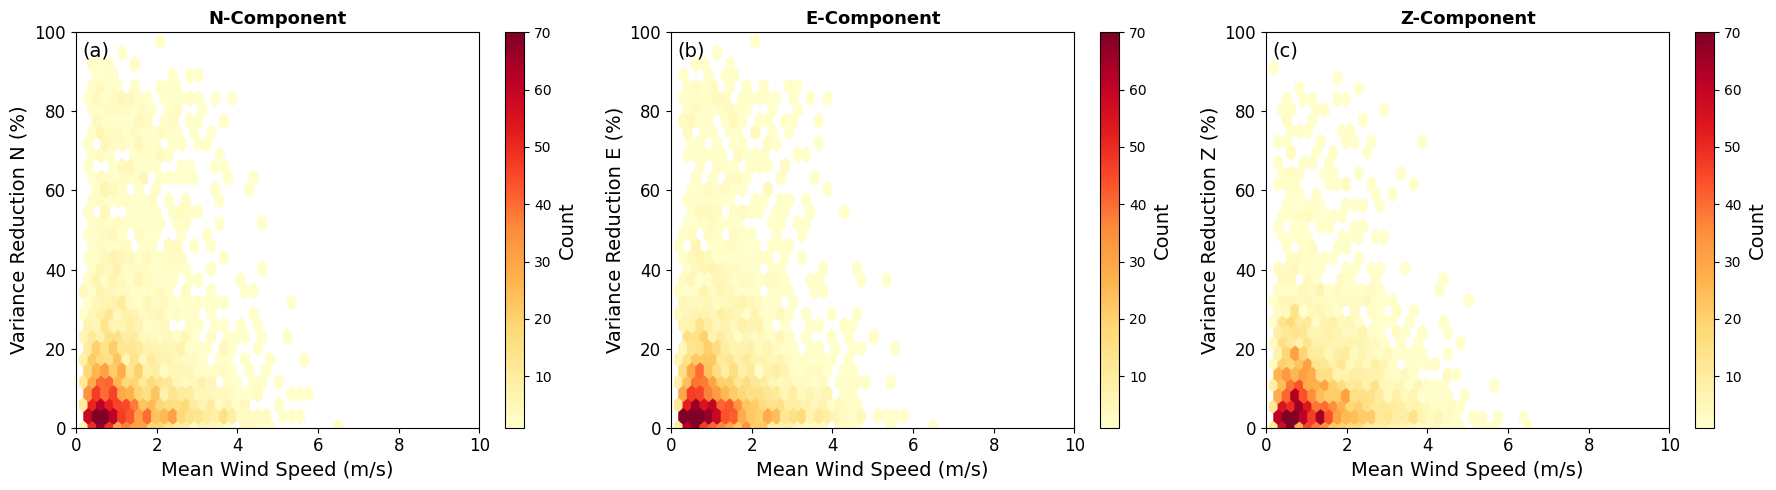

In [7]:
# Remove rows with NaN values for cleaner plots
df_clean = df_filtered.dropna(subset=['var_red_N', 'var_red_E', 'var_red_Z', 
                                    'wind_speed_mean', 'wind_dir_mean'])
print(f"Clean dataset for plotting: {len(df_clean)} records")

# Setup
components = ['N', 'E', 'Z']
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create figure with heatmaps only
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, comp in enumerate(components):
    var_col = f'var_red_{comp}'
    ax_heat = axes[idx]
    
    x = df_clean['wind_speed_mean'].values
    y = df_clean[var_col].values
    
    # Create 2D histogram/heatmap
    hb = ax_heat.hexbin(x, y, gridsize=30, cmap='YlOrRd', mincnt=1, vmax=70)
    ax_heat.set_xlabel('Mean Wind Speed (m/s)', fontsize=14)
    ax_heat.set_ylabel(f'Variance Reduction {comp} (%)', fontsize=14)
    
    # Calculate correlation for title
    corr = np.corrcoef(x, y)[0, 1]
    ax_heat.set_title(f'{comp}-Component', fontsize=13, fontweight='bold')
    ax_heat.set_ylim(0, 100)
    ax_heat.set_xlim(0, 10)
    
    # Increase tick label size
    ax_heat.tick_params(axis='both', which='major', labelsize=12)

    # Add colorbar
    cb = plt.colorbar(hb, ax=ax_heat)
    cb.set_label('Count', fontsize=14)

    # add label to the top left of the plot
    ax_heat.text(0.015, 0.94, f'({chr(97+idx)})', fontsize=14, transform=ax_heat.transAxes)

# plt.suptitle('Variance Reduction vs Wind Speed Mean', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

fig.savefig('figures/variance_reduction_vs_wind_speed_mean.png', dpi=200, bbox_inches='tight')

### 3.2 Variance Reduction vs Wind Speed Max

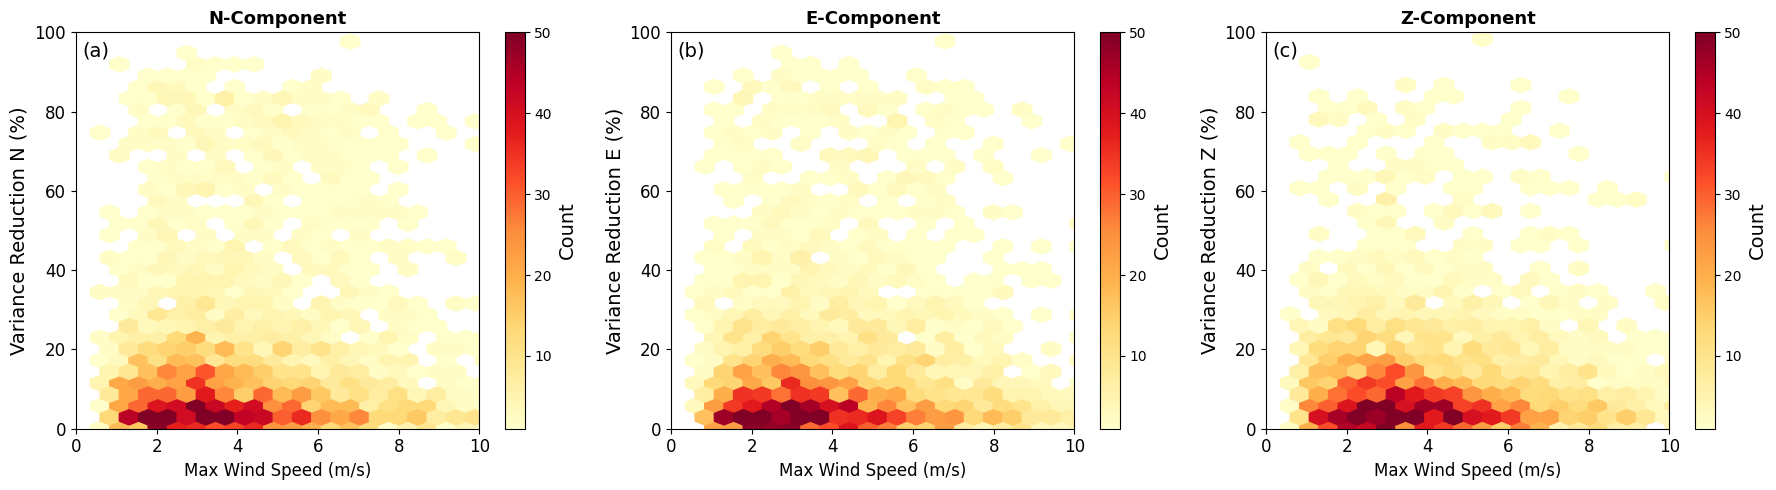

In [8]:
# Create figure with heatmaps only
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, comp in enumerate(components):
    var_col = f'var_red_{comp}'
    ax_heat = axes[idx]
    
    x = df_filtered['wind_speed_max'].values
    y = df_filtered[var_col].values
    
    # Create 2D histogram/heatmap
    hb = ax_heat.hexbin(x, y, gridsize=30, cmap='YlOrRd', mincnt=1, vmax=50)
    ax_heat.set_xlabel('Max Wind Speed (m/s)', fontsize=12)
    ax_heat.set_ylabel(f'Variance Reduction {comp} (%)', fontsize=14)
    
    # Calculate correlation for title
    corr = np.corrcoef(x, y)[0, 1]
    ax_heat.set_title(f'{comp}-Component', fontsize=13, fontweight='bold')
    ax_heat.set_ylim(0, 100)
    ax_heat.set_xlim(0, 10)
    
    # Increase tick label size
    ax_heat.tick_params(axis='both', which='major', labelsize=12)

    # Add colorbar
    cb = plt.colorbar(hb, ax=ax_heat)
    cb.set_label('Count', fontsize=14)
   
    # add label to the top left of the plot
    ax_heat.text(0.015, 0.94, f'({chr(97+idx)})', fontsize=14, transform=ax_heat.transAxes)

# plt.suptitle('Variance Reduction vs Wind Speed Max', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

fig.savefig('figures/variance_reduction_vs_wind_speed_max.png', dpi=200, bbox_inches='tight')

### 3.3 Variance Reduction vs Wind Direction Mean

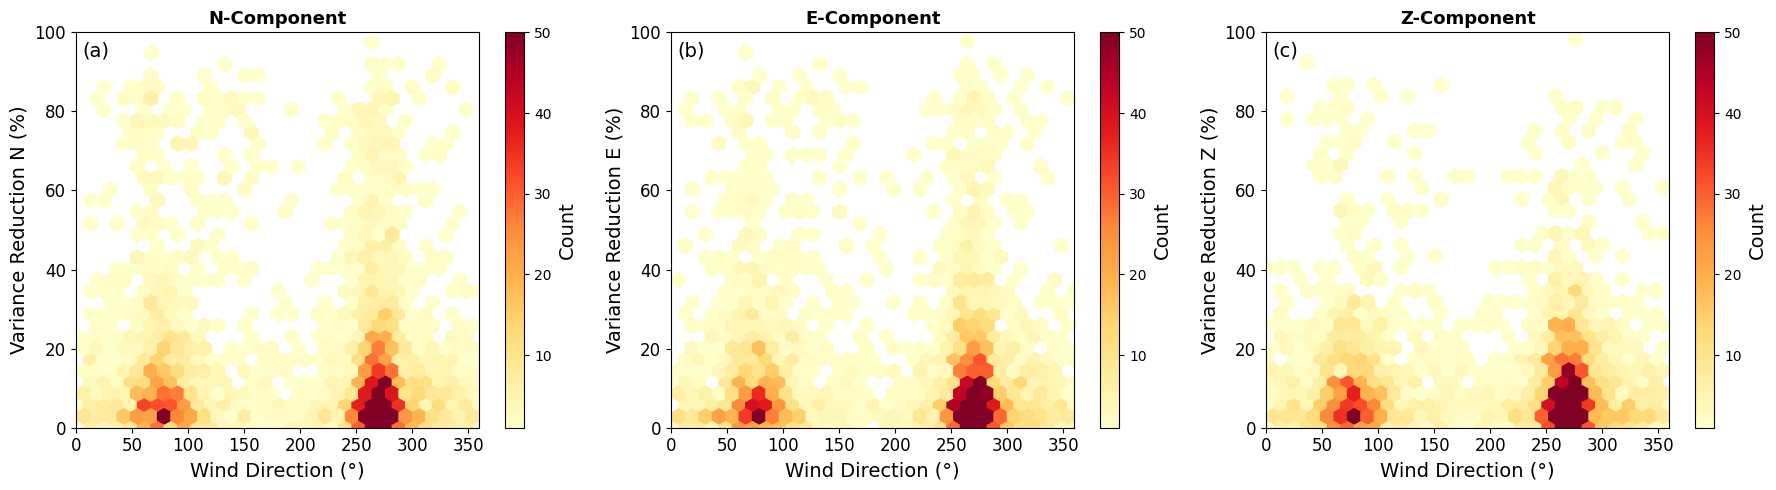

In [9]:
# Create figure with heatmaps only
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, comp in enumerate(components):
    var_col = f'var_red_{comp}'
    ax_heat = axes[idx]
    
    x = df_filtered['wind_dir_mean'].values
    y = df_filtered[var_col].values
    
    # Create 2D histogram/heatmap
    hb = ax_heat.hexbin(x, y, gridsize=30, cmap='YlOrRd', mincnt=1, vmax=50)
    ax_heat.set_xlabel('Wind Direction (°)', fontsize=14)
    ax_heat.set_ylabel(f'Variance Reduction {comp} (%)', fontsize=14)
    
    # Calculate correlation for title
    corr = np.corrcoef(x, y)[0, 1]
    ax_heat.set_title(f'{comp}-Component', fontsize=13, fontweight='bold')
    ax_heat.set_xlim(0, 360)
    ax_heat.set_ylim(0, 100)
    
    # Increase tick label size
    ax_heat.tick_params(axis='both', which='major', labelsize=12)
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax_heat)
    cb.set_label('Count', fontsize=14)

    # add label to the top left of the plot
    ax_heat.text(0.015, 0.94, f'({chr(97+idx)})', fontsize=14, transform=ax_heat.transAxes)

# plt.suptitle('Variance Reduction vs Wind Direction Mean', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

fig.savefig('figures/variance_reduction_vs_wind_direction.png', dpi=200, bbox_inches='tight')

## 4. Statistical Summary

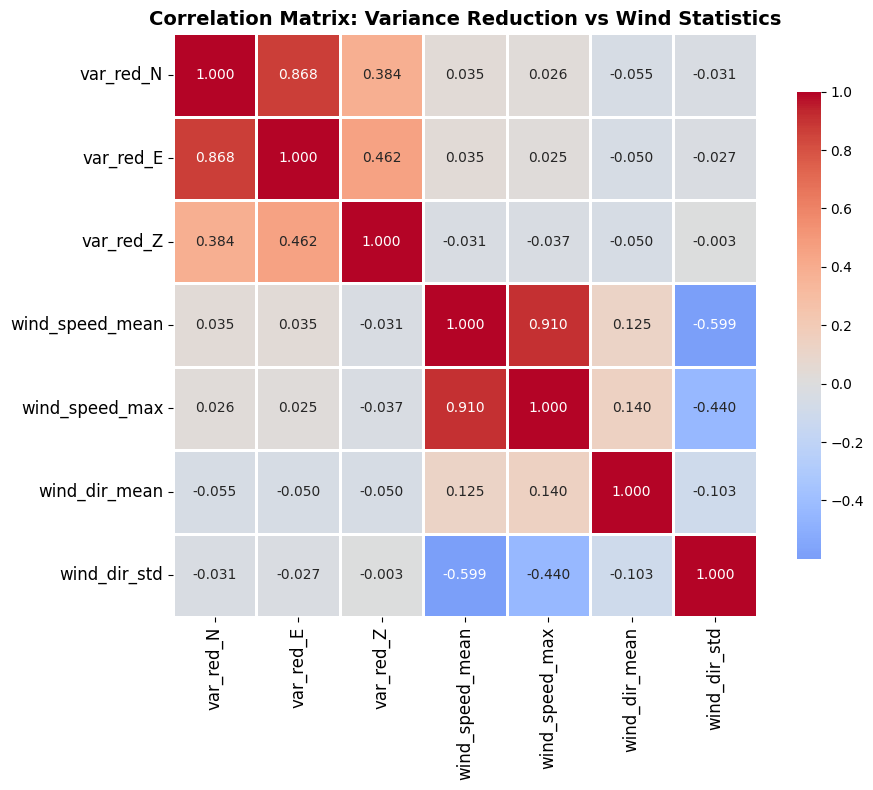

In [10]:
# Calculate correlation matrix
corr_vars = ['var_red_N', 'var_red_E', 'var_red_Z', 
             'wind_speed_mean', 'wind_speed_max', 'wind_dir_mean', 'wind_dir_std']
df_corr = df_clean[corr_vars].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Variance Reduction vs Wind Statistics', fontsize=14, fontweight='bold')

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [11]:
# Print summary statistics
print("="*70)
print("CORRELATION SUMMARY")
print("="*70)

wind_stats = ['wind_speed_mean', 'wind_speed_max', 'wind_dir_mean', 'wind_dir_std']

for comp in components:
    var_col = f'var_red_{comp}'
    print(f"\n{comp}-Component Variance Reduction:")
    for wind_stat in wind_stats:
        df_temp = df_clean.dropna(subset=[var_col, wind_stat])
        if len(df_temp) > 1:
            corr = np.corrcoef(df_temp[var_col], df_temp[wind_stat])[0, 1]
            print(f"  vs {wind_stat}: {corr:.4f}")
    print(f"  Mean VR: {df_clean[var_col].mean():.2f}%")
    print(f"  Std VR: {df_clean[var_col].std():.2f}%")

CORRELATION SUMMARY

N-Component Variance Reduction:
  vs wind_speed_mean: 0.0352
  vs wind_speed_max: 0.0264
  vs wind_dir_mean: -0.0552
  vs wind_dir_std: -0.0308
  Mean VR: 16.54%
  Std VR: 20.19%

E-Component Variance Reduction:
  vs wind_speed_mean: 0.0348
  vs wind_speed_max: 0.0247
  vs wind_dir_mean: -0.0496
  vs wind_dir_std: -0.0274
  Mean VR: 14.74%
  Std VR: 18.37%

Z-Component Variance Reduction:
  vs wind_speed_mean: -0.0306
  vs wind_speed_max: -0.0367
  vs wind_dir_mean: -0.0497
  vs wind_dir_std: -0.0033
  Mean VR: 11.90%
  Std VR: 13.65%


## 5. Wind Direction vs Wind Speed Heatmaps

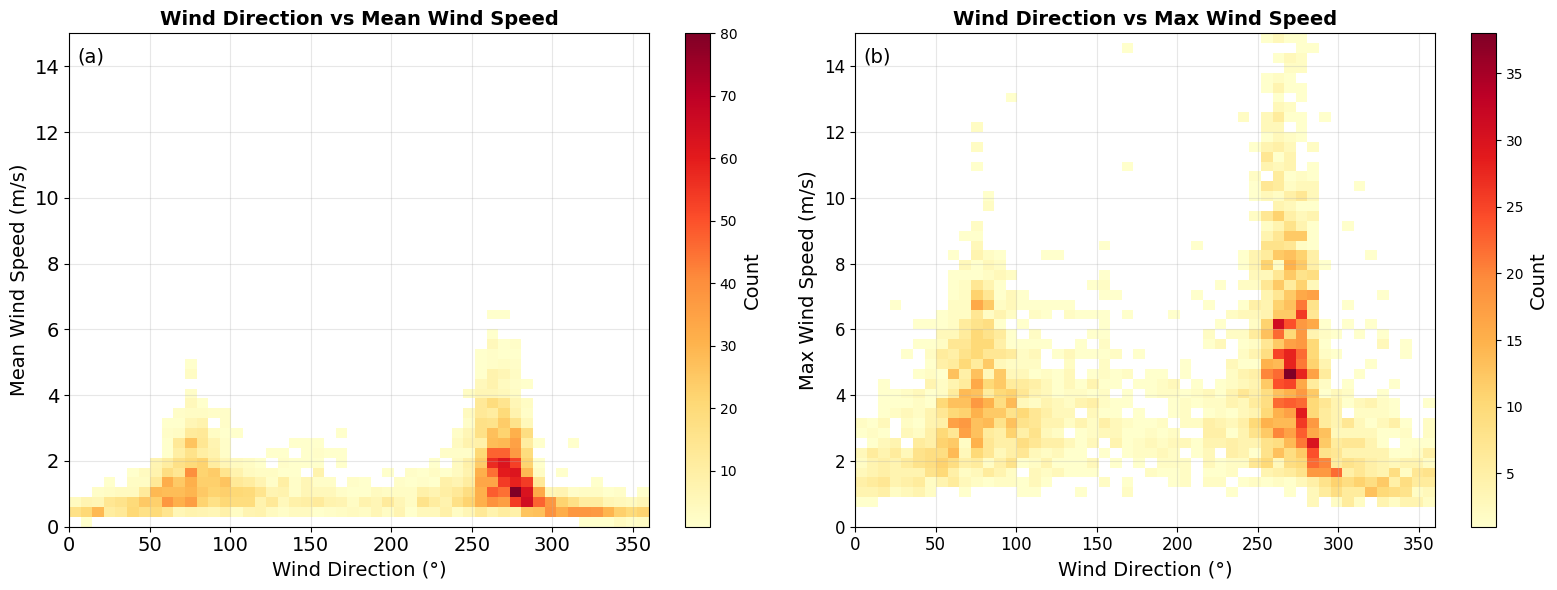


Wind Direction vs Wind Speed Statistics:
  Total data points: 4457
  Wind direction range: 0.0° - 360.0°
  Wind speed mean range: 0.20 - 6.50 m/s
  Wind speed max range: 0.60 - 14.90 m/s


In [12]:
# Create heatmaps showing wind direction vs wind speed
# Filter out NaN values
df_wind_plot = df_filtered.dropna(subset=['wind_dir_mean', 'wind_speed_mean', 'wind_speed_max'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Wind Direction vs Wind Speed Mean
ax1 = axes[0]
x = df_wind_plot['wind_dir_mean'].values
y = df_wind_plot['wind_speed_mean'].values

cmap = plt.cm.YlOrRd
cmap.set_under('white')
cmap.set_bad('white', alpha=1)

# Create 2D histogram heatmap
# hist2d returns (counts, xedges, yedges, image)
counts1, xedges1, yedges1, im1 = ax1.hist2d(x, y, bins=50, range=([0, 360], [0, 15]), cmap=cmap, vmin=1)
ax1.set_xlabel('Wind Direction (°)', fontsize=14)
ax1.set_ylabel('Mean Wind Speed (m/s)', fontsize=14)
ax1.set_title('Wind Direction vs Mean Wind Speed', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 360)
ax1.set_ylim(0, 15)
ax1.grid(True, alpha=0.3)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=14)

# Add colorbar (use the image from hist2d)
cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Count', fontsize=14)

# add label to the top left of the plot
ax1.text(0.015, 0.94, f'({chr(97)})', fontsize=14, transform=ax1.transAxes)

# Plot 2: Wind Direction vs Wind Speed Max
ax2 = axes[1]
x = df_wind_plot['wind_dir_mean'].values
y = df_wind_plot['wind_speed_max'].values

# Create 2D histogram heatmap
# hist2d returns (counts, xedges, yedges, image)
counts2, xedges2, yedges2, im2 = ax2.hist2d(x, y, bins=50, range=([0, 360], [0, 15]), cmap=cmap, vmin=1)
ax2.set_xlabel('Wind Direction (°)', fontsize=14)
ax2.set_ylabel('Max Wind Speed (m/s)', fontsize=14)
ax2.set_title('Wind Direction vs Max Wind Speed', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 360)
ax2.set_ylim(0, 15)
ax2.grid(True, alpha=0.3)

# Increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=12)

# Add colorbar (use the image from hist2d)
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Count', fontsize=14)

# add label to the top left of the plot
ax2.text(0.015, 0.94, f'({chr(97+1)})', fontsize=14, transform=ax2.transAxes)

# plt.suptitle('Wind Direction vs Wind Speed Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


fig.savefig('figures/wind_direction_vs_wind_speed.png', dpi=200, bbox_inches='tight')

# Print summary statistics
print(f"\nWind Direction vs Wind Speed Statistics:")
print(f"  Total data points: {len(df_wind_plot)}")
print(f"  Wind direction range: {df_wind_plot['wind_dir_mean'].min():.1f}° - {df_wind_plot['wind_dir_mean'].max():.1f}°")
print(f"  Wind speed mean range: {df_wind_plot['wind_speed_mean'].min():.2f} - {df_wind_plot['wind_speed_mean'].max():.2f} m/s")
print(f"  Wind speed max range: {df_wind_plot['wind_speed_max'].min():.2f} - {df_wind_plot['wind_speed_max'].max():.2f} m/s")